In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import librosa
import librosa.display
import IPython.display

In [2]:
!ls /content

sample_data


In [7]:
X = np.load('/content/sample_data/ei-lab03-mfcc-X_training.npy')
Y = np.load('/content/sample_data/ei-lab03-mfcc-y_training.npy')[:,0]

In [8]:
X.shape, Y.shape

((224, 650), (224,))

In [9]:
image = X[0]
img_length = image.shape[0]
img_length

650

In [10]:
columns = 13
rows = int(img_length / columns)
image = np.reshape(image, (rows, columns))
image.shape

(50, 13)

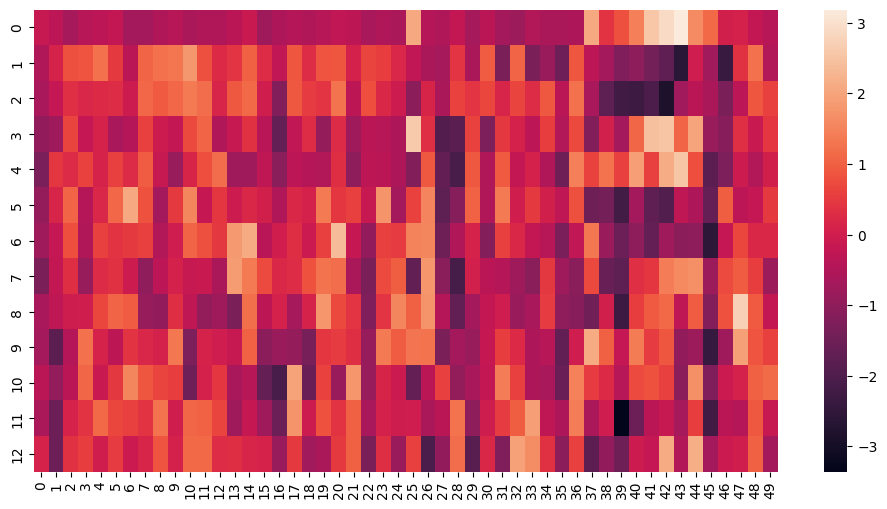

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(image.T);

In [12]:
Y[0]

3

In [13]:
# Find the unique labels and their counts
unique_labels, counts = np.unique(Y, return_counts=True)

# Display the unique labels and their counts
print("Unique labels:", unique_labels)
print("Counts:", counts)

Unique labels: [1 2 3]
Counts: [95 68 61]


In [15]:
classes_values = [ "test", "training", "silence" ]
classes = len(classes_values)

In [16]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.1,
    random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [17]:
def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=20)

callbacks = [early_stop]

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
model.add(Reshape((int(input_length / 13), 13), input_shape=(input_length, )))
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(classes, activation='softmax', name='y_pred'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 50, 13)            0         
                                                                 
 conv1d (Conv1D)             (None, 50, 8)             320       
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 8)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 25, 8)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            400       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 13, 16)            0         
 g1D)                                                   

In [20]:
LR = 0.005
BS = 32
EPOCHS = 100

In [21]:
# this controls the learning rate
opt = Adam(lr=LR, beta_1=0.9, beta_2=0.999)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = BS
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, verbose=2, callbacks=callbacks)

Epoch 1/100
7/7 - 1s - loss: 1.2950 - accuracy: 0.3731 - val_loss: 1.2635 - val_accuracy: 0.2609 - 1s/epoch - 210ms/step
Epoch 2/100
7/7 - 0s - loss: 1.2558 - accuracy: 0.3980 - val_loss: 1.1328 - val_accuracy: 0.2609 - 44ms/epoch - 6ms/step
Epoch 3/100
7/7 - 0s - loss: 1.1926 - accuracy: 0.4080 - val_loss: 1.1097 - val_accuracy: 0.3043 - 44ms/epoch - 6ms/step
Epoch 4/100
7/7 - 0s - loss: 1.1772 - accuracy: 0.3831 - val_loss: 1.1220 - val_accuracy: 0.2609 - 62ms/epoch - 9ms/step
Epoch 5/100
7/7 - 0s - loss: 1.1601 - accuracy: 0.4129 - val_loss: 1.1301 - val_accuracy: 0.2609 - 48ms/epoch - 7ms/step
Epoch 6/100
7/7 - 0s - loss: 1.1912 - accuracy: 0.4030 - val_loss: 1.1160 - val_accuracy: 0.2609 - 45ms/epoch - 6ms/step
Epoch 7/100
7/7 - 0s - loss: 1.1272 - accuracy: 0.3980 - val_loss: 1.1080 - val_accuracy: 0.3043 - 42ms/epoch - 6ms/step
Epoch 8/100
7/7 - 0s - loss: 1.1188 - accuracy: 0.4328 - val_loss: 1.0928 - val_accuracy: 0.3043 - 43ms/epoch - 6ms/step
Epoch 9/100
7/7 - 0s - loss: 1.0

In [22]:
def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('Test Accuracy: {acc:0.3f}'.format(acc=test_acc))

def plot_result(history, res= 'loss'):
    plt.plot(history.history[res])
    plt.plot(history.history['val_'+res])
    plt.title(res+' vs. epochs')
    plt.ylabel(res)
    plt.xlabel('Epoch')
    plt.grid()
    if (res == 'loss'):
        plt.legend(['training', 'validation'], loc='upper right')
    else:
        plt.legend(['training', 'validation'], loc='lower right')
    plt.show()

In [23]:
get_test_accuracy(model, X_test, Y_test)

Test Accuracy: 1.000


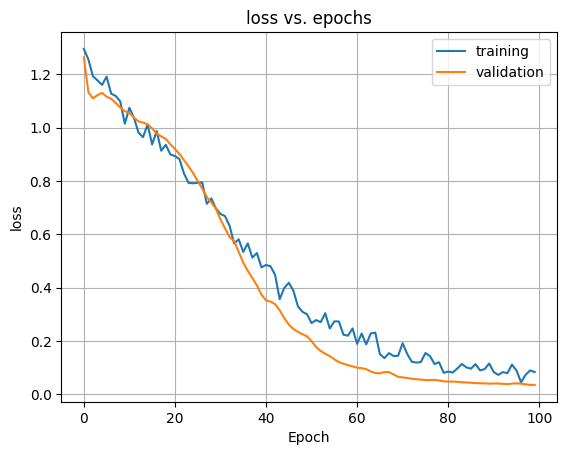

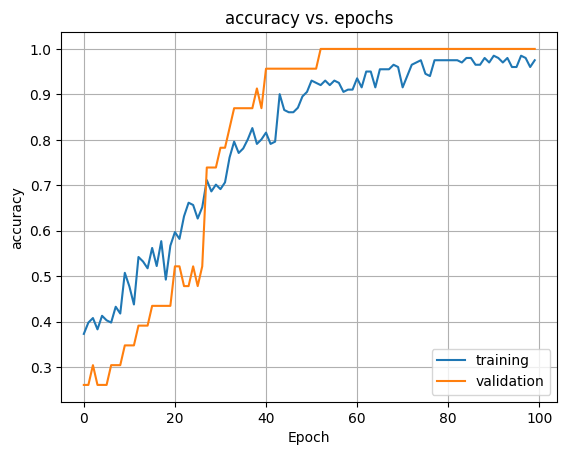

In [24]:
plot_result(history, res= 'loss')
plot_result(history, res= 'accuracy')

In [25]:
# Save the model to disk
model.save('cnn_v1_saved_model')

In [26]:
# Convert TF model to a tflite model
from tensorflow.keras.models import load_model

model_cnn_v1 = load_model('cnn_v1_saved_model')
converter = tf.lite.TFLiteConverter.from_keras_model(model_cnn_v1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tflite_model_size = open("cnn_v1.tflite","wb").write(tflite_model)
print("Quantized model (DEFAULT) is {:,} bytes".format(tflite_model_size))

Quantized model (DEFAULT) is 11,432 bytes
